# VLB Large-Amplitude Oscillatory Shear (LAOS)

**VLB transient network — LAOS simulation and Lissajous figures**

## Context: VLB LAOS Predictions

Under imposed strain $\gamma(t) = \gamma_0 \sin(\omega t)$, the VLB evolution ODE:

$$\dot{\mu}_{xy} = -k_d \mu_{xy} + \gamma_0 \omega \cos(\omega t)$$

is **linear** with sinusoidal forcing → the solution is purely at frequency $\omega$. Therefore $\sigma_{12} = G_0 \mu_{xy}$ has **no higher harmonics** ($I_3/I_1 \approx 0$).

However, $N_1 = G_0(\mu_{xx} - \mu_{yy})$ involves $\mu_{xx}$ which is driven by $2\dot{\gamma}\mu_{xy}$ — a product of two oscillatory quantities — producing **$2\omega$ harmonics** in $N_1$ even with constant $k_d$.

**Critical diagnostic:** Constant-$k_d$ VLB is **linear in shear stress** but **nonlinear in normal stress**. Nonzero $I_3/I_1$ in $\sigma_{12}$ requires force-dependent $k_d$ (Bell model, Notebook 08) or finite extensibility (FENE-P, Notebook 09).

> **Handbook:** See [VLB Protocols](../../docs/source/models/vlb/vlb_protocols.rst) for LAOS ODE solutions, [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for nonlinearity diagnostics.

## Learning Objectives

- Simulate LAOS response using ODE integration
- Observe that $\sigma_{12}$ is linear (no higher harmonics) with constant $k_d$
- Observe that $N_1$ has $2\omega$ harmonics even with constant $k_d$
- Construct Lissajous figures

## Estimated Runtime

- ~2-3 min (ODE integration via diffrax)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

Under $\gamma(t) = \gamma_0 \sin(\omega t)$, the VLB ODE is:

$$\dot{\mu}_{xy} = -k_d \mu_{xy} + \gamma_0 \omega \cos(\omega t)$$

This is a **linear** ODE with sinusoidal forcing → solution is purely at frequency $\omega$.

Therefore $\sigma_{12} = G_0 \mu_{xy}$ has **no higher harmonics** ($I_3/I_1 \approx 0$).

However, $N_1 = G_0(\mu_{xx} - \mu_{yy})$ involves $\mu_{xx}$ which is driven by $2\dot{\gamma}\mu_{xy}$ — a product of two oscillatory quantities — producing **$2\omega$ harmonics** in $N_1$.

This is a fundamental prediction: **constant $k_d$ VLB is linear in shear stress but nonlinear in normal stress**.

In [3]:
model = VLBLocal()
model.parameters.set_value("G0", 5000.0)
model.parameters.set_value("k_d", 2.0)

gamma_0 = 1.0   # Strain amplitude
omega = 1.0      # Frequency [rad/s]
n_cycles = 10    # Number of cycles

print(f"γ₀ = {gamma_0}")
print(f"ω = {omega} rad/s")
print(f"Wi = γ₀·ω/k_d = {gamma_0 * omega / model.k_d:.2f}")

γ₀ = 1.0
ω = 1.0 rad/s
Wi = γ₀·ω/k_d = 0.50


In [4]:
# Simulate LAOS — construct time array spanning n_cycles periods
T = 2 * np.pi / omega
t = np.linspace(0.0, n_cycles * T, n_cycles * 200)
result = model.simulate_laos(t, gamma_0=gamma_0, omega=omega)

t = np.array(result["time"])
sigma = np.array(result["stress"])
N1 = np.array(result["N1"])
gamma = gamma_0 * np.sin(omega * t)
gamma_dot = gamma_0 * omega * np.cos(omega * t)

print(f"Simulated {n_cycles} cycles, {len(t)} time points")

Simulated 10 cycles, 2000 time points


## 3. Time Series

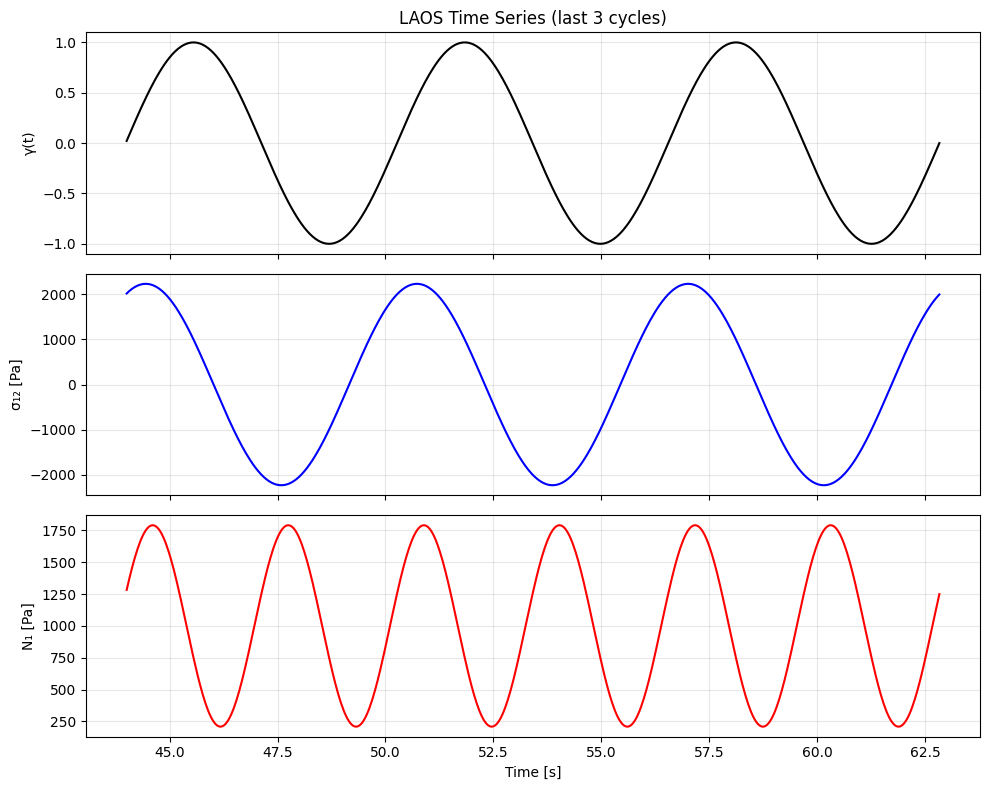

In [5]:
# Show last 3 cycles
T = 2 * np.pi / omega
t_start = (n_cycles - 3) * T
mask = t >= t_start

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax1.plot(t[mask], gamma[mask], "k-", lw=1.5)
ax1.set_ylabel("γ(t)")
ax1.set_title("LAOS Time Series (last 3 cycles)")
ax1.grid(True, alpha=0.3)

ax2.plot(t[mask], sigma[mask], "b-", lw=1.5)
ax2.set_ylabel("σ₁₂ [Pa]")
ax2.grid(True, alpha=0.3)

ax3.plot(t[mask], N1[mask], "r-", lw=1.5)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("N₁ [Pa]")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Lissajous Figures

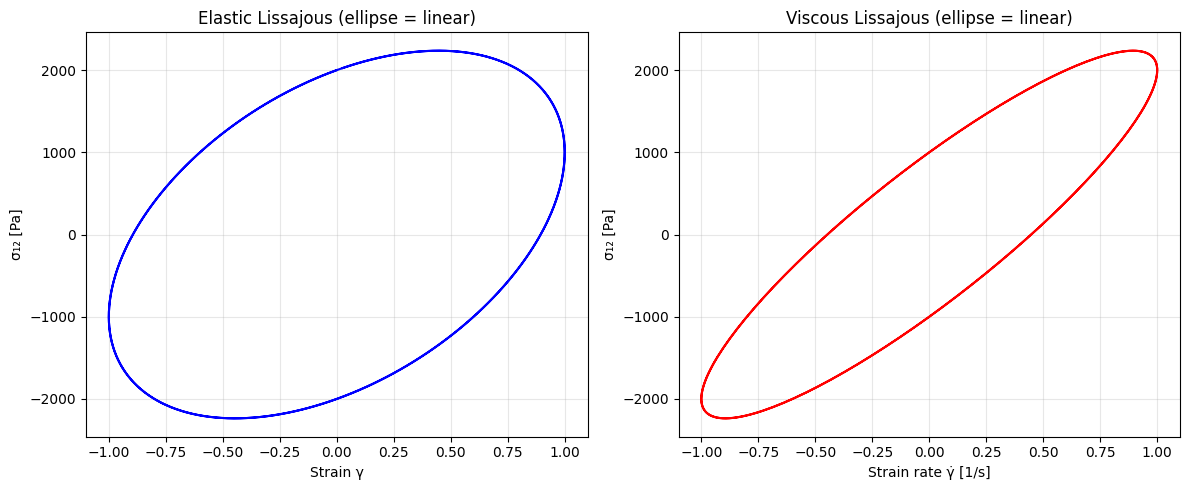

In [6]:
# Use last 2 cycles for clean Lissajous
t_liss_start = (n_cycles - 2) * T
mask_liss = t >= t_liss_start

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elastic Lissajous: σ vs γ
ax1.plot(gamma[mask_liss], sigma[mask_liss], "b-", lw=1.5)
ax1.set_xlabel("Strain γ")
ax1.set_ylabel("σ₁₂ [Pa]")
ax1.set_title("Elastic Lissajous (ellipse = linear)")
ax1.grid(True, alpha=0.3)

# Viscous Lissajous: σ vs γ̇
ax2.plot(gamma_dot[mask_liss], sigma[mask_liss], "r-", lw=1.5)
ax2.set_xlabel("Strain rate γ̇ [1/s]")
ax2.set_ylabel("σ₁₂ [Pa]")
ax2.set_title("Viscous Lissajous (ellipse = linear)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Harmonic Analysis

Verify that σ₁₂ has no higher harmonics while N₁ has 2ω content.

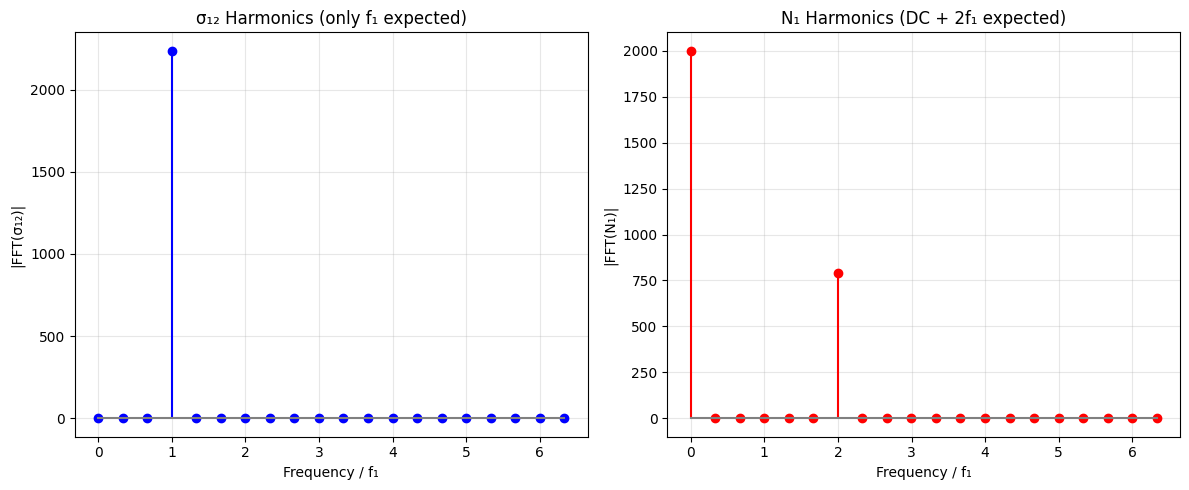

σ₁₂ nonlinearity: I₃/I₁ = 1.99e-04 (should be ~0)
N₁ has DC component and 2ω harmonic as expected


In [7]:
# FFT analysis on steady-state cycles
mask_ss = t >= (n_cycles - 3) * T
sigma_ss = sigma[mask_ss]
N1_ss = N1[mask_ss]
n_pts = len(sigma_ss)

# FFT
freq = np.fft.rfftfreq(n_pts, d=(t[mask_ss][1] - t[mask_ss][0]))
sigma_fft = np.abs(np.fft.rfft(sigma_ss)) / n_pts * 2
N1_fft = np.abs(np.fft.rfft(N1_ss)) / n_pts * 2

# Fundamental frequency
f1 = omega / (2 * np.pi)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.stem(freq[:20] / f1, sigma_fft[:20], linefmt="b-", markerfmt="bo", basefmt="gray")
ax1.set_xlabel("Frequency / f₁")
ax1.set_ylabel("|FFT(σ₁₂)|")
ax1.set_title("σ₁₂ Harmonics (only f₁ expected)")
ax1.grid(True, alpha=0.3)

ax2.stem(freq[:20] / f1, N1_fft[:20], linefmt="r-", markerfmt="ro", basefmt="gray")
ax2.set_xlabel("Frequency / f₁")
ax2.set_ylabel("|FFT(N₁)|")
ax2.set_title("N₁ Harmonics (DC + 2f₁ expected)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

# Nonlinearity ratio
I1_idx = np.argmin(np.abs(freq - f1))
I3_idx = np.argmin(np.abs(freq - 3*f1))
if sigma_fft[I1_idx] > 0:
    I3_I1 = sigma_fft[I3_idx] / sigma_fft[I1_idx]
    print(f"σ₁₂ nonlinearity: I₃/I₁ = {I3_I1:.2e} (should be ~0)")
print(f"N₁ has DC component and 2ω harmonic as expected")

## Key Takeaways

1. **$\sigma_{12}$ is linear** in LAOS with constant $k_d$ — perfect elliptical Lissajous
2. **$N_1$ has $2\omega$ harmonics** — normal stress is inherently nonlinear even for linear shear stress
3. **True LAOS nonlinearity** ($I_3 > 0$ in $\sigma_{12}$) requires force-dependent $k_d$ (Bell model)
4. **Lissajous figures** are ellipses — deviations indicate non-Maxwell behavior

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — LAOS ODE system, normal stress predictions
- [VLB Protocols](../../docs/source/models/vlb/vlb_protocols.rst) — analytical solutions for linear regime
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Next Steps

- **Notebook 07**: Full Bayesian workflow
- **Notebook 08**: Bell model with shear-thinning LAOS
- **Notebook 09**: FENE-P model with bounded extension